# Simulation Health Report

General Settings
========

Mandatory Settings
----------------
* `store_directory`: Location where the experiment was run. This has an `analysis.yaml` file and two `.nc` files.

Optional Settings
----------------
* `decorrelation_threshold`: When number of decorrelated samples is less than this percent of the total number of samples, raise a warning. Default: `0.1`.
* `mixing_cutoff`: Minimal level of mixing percent from state `i` to `j` that will be plotted. Default: `0.05`.
* `mixing_warning_threshold`: Level of mixing where transition from state `i` to `j` generates a warning based on percent of total swaps. Default: `0.90`.
* `phase_stacked_replica_plots`: Boolean to set if the two phases' replica mixing plots should be stacked one on top of the other or side by side. If `True`, every replica will span the whole notebook, but the notebook will be longer. If `False`, the two phases' plots will be next to each other for a shorter notebook, but a more compressed view. Default `False`.

In [1]:
# Mandatory Settings
store_directory = 'REMD_T/prueba.nc'

# Optional Settings
decorrelation_threshold = 0.1
mixing_cutoff = 0.05
mixing_warning_threshold = 0.90
phase_stacked_replica_plots = False

In [23]:
import numpy as np
from scipy import interpolate
from matplotlib import pyplot as plt
from matplotlib import axes as axes
from matplotlib import gridspec
from yank import analyze
%matplotlib inline

In [28]:
analyzer = analyze.get_analyzer(store_directory)
nphases = 1
phase_name = "REPEX Temperature"

### General simulation data

In [29]:
positions = analyzer.reporter.read_sampler_states(0)[0].positions
natoms, _ = positions.shape
energies, _ = analyzer.reporter.read_energies()
iterations, nstates, _ = energies.shape

# print(positions)
print(natoms)
# print(energies)
print(iterations)
print(nstates)

1
1001
8


# Equilibration Plots

Text(0.5,0,'Iteration')

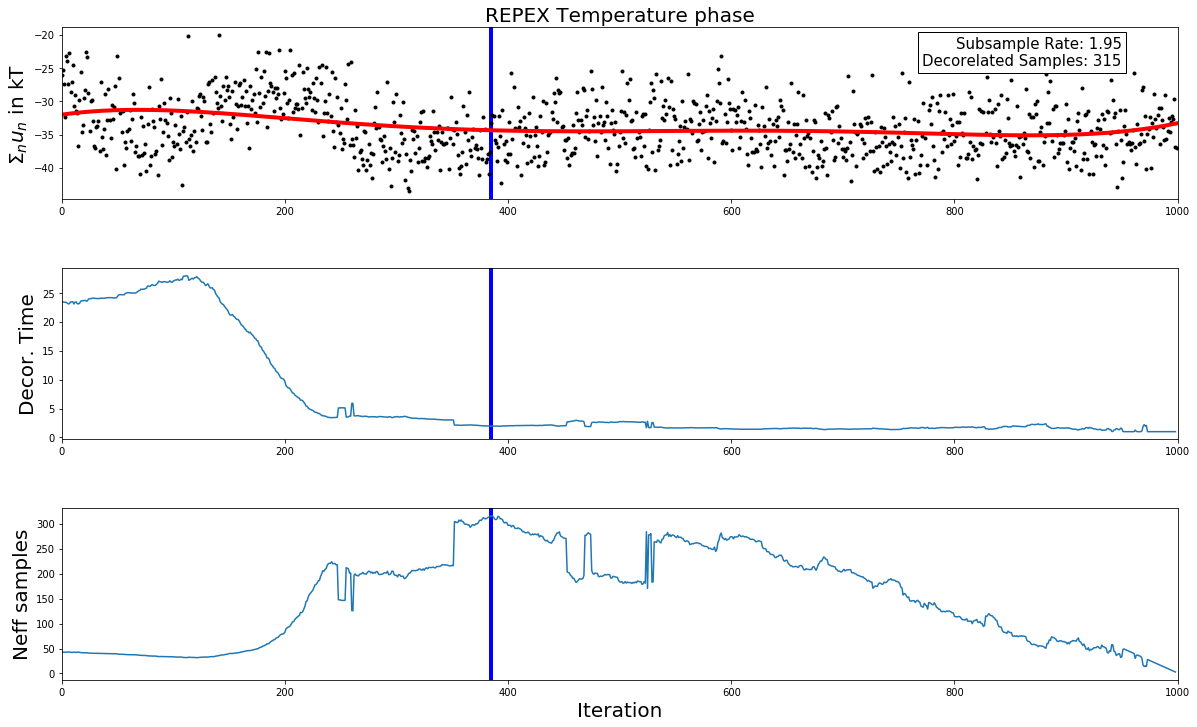

In [32]:
discard_from_start=1


plt.rcParams['figure.figsize'] = 20, 6 * nphases * 2
plot_grid = gridspec.GridSpec(nphases, 1)  # Vertical distribution
equilibration_figure = plt.figure()
# Add some space between the figures
equilibration_figure.subplots_adjust(hspace=0.4)
sub_grid = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=plot_grid[0])

# Data crunching to get timeseries
u_kln, _ = analyzer.get_states_energies()
# TODO: Figure out how not to discard the first sample
# Sample at index 0 is actually the minimized structure and NOT from the equilibrium distribution
# This throws off all of the equilibrium data
u_kln = u_kln[:, :, discard_from_start:]
_n_discarded = discard_from_start
u_ns = analyzer.get_timeseries(u_kln)
# Timeseries statistics
g_t, Neff_t = analyze.get_equilibration_data_per_sample(u_ns)
Neff_maxs = Neff_t.max()
nequils = Neff_t.argmax()
g_ts = g_t[int(nequils)]

# FIRST SUBPLOT: energy scatter
# Attach subplot to figure
p = equilibration_figure.add_subplot(sub_grid[0])
y = u_ns
N = y.size
x = np.arange(N)
# Scatter plot
p.plot(x, y, 'k.')
# Smoothed equilibrium, this is very crude but it works for large data
tck = interpolate.splrep(x, y, k=5, s=N * 1E7)
smoothed = interpolate.splev(x, tck, der=0)
p.plot(x, smoothed, '-r', linewidth=4)
# Nequil line
ylim = p.get_ylim()
p.vlines(nequils, *ylim, colors='b', linewidth=4)
p.set_ylim(*ylim)  # Reset limits in case vlines expanded them
p.set_xlim([0, N])
# Set text
p.set_title(phase_name + " phase", fontsize=20)
p.set_ylabel(r'$\Sigma_n u_n$ in kT', fontsize=20)

# Extra info in text boxes
subsample_string = 'Subsample Rate: {0:.2f}\nDecorelated Samples: {1:d}'.format(g_ts, int(np.floor(Neff_maxs)))
if np.mean([0, N]) > nequils:
    txt_horz = 'right'
    txt_xcoord = 0.95
else:
    txt_horz = 'left'
    txt_xcoord = 0.05
smooth_index = {'right': -1, 'left': 0}  # condition y
if np.mean(ylim) > smoothed[smooth_index[txt_horz]]:
    txt_vert = 'top'
    txt_ycoord = 0.95
else:
    txt_vert = 'bottom'
    txt_ycoord = 0.05
p.text(txt_xcoord, txt_ycoord,
       subsample_string,
       verticalalignment=txt_vert, horizontalalignment=txt_horz,
       transform=p.transAxes,
       fontsize=15,
       bbox={'alpha': 1.0, 'facecolor': 'white'}
       )


# SECOND SUBPLOT: g_t trace
g = equilibration_figure.add_subplot(sub_grid[1])
g.plot(x[:-1], g_t)
ylim = g.get_ylim()
g.vlines(nequils, *ylim, colors='b', linewidth=4)
g.set_ylim(*ylim)  # Reset limits in case vlines expanded them
g.set_xlim([0, N])
g.set_ylabel(r'Decor. Time', fontsize=20)


# THRID SUBPLOT: Neff trace
ne = equilibration_figure.add_subplot(sub_grid[2])
ne.plot(x[:-1], Neff_t)
ylim = ne.get_ylim()
ne.vlines(nequils, *ylim, colors='b', linewidth=4)
ne.set_ylim(*ylim)  # Reset limits in case vlines expanded them
ne.set_xlim([0, N])
ne.set_ylabel(r'Neff samples', fontsize=20)
ne.set_xlabel(r'Iteration', fontsize=20)




# Decorrelation Plots

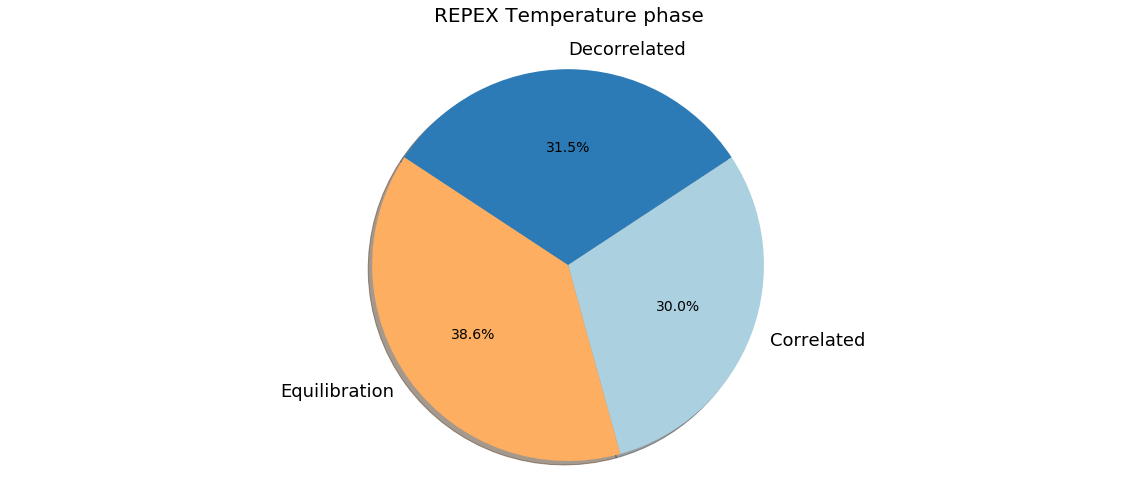

In [38]:
plt.rcParams['figure.figsize'] = 20, 8
decorrelation_figure = plt.figure()
decorrelation_figure.subplots_adjust(wspace=0.2)
plotkeys = [100 + (10 * nphases) + (i + 1) for i in range(nphases)]  # Horizonal distribution
plotid=plotkeys[0]

p = decorrelation_figure.add_subplot(plotid)
# Determine toal number of iterations
N = iterations
labels = ['Decorrelated', 'Correlated', 'Equilibration']
colors = ['#2c7bb6', '#abd0e0', '#fdae61']  # blue, light blue, and orange
explode = [0, 0, 0.0]
# Determine the wedges
eq = nequils + _n_discarded  # Make sure we include the discarded
decor = int(np.floor(Neff_maxs))
cor = N - eq - decor
dat = np.array([decor, cor, eq]) / float(N)
if dat[0] <= decorrelation_threshold:
    colors[0] = '#d7191c'  # Red for warning
patch, txt, autotxt = p.pie(
    dat,
    explode=explode,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    shadow=True,
    startangle=90 + 360 * dat[0] / 2,  # put center of decor at top
    counterclock=False,
    textprops={'fontsize': 14}
)
for tx in txt:  # This is the only way I have found to adjust the label font size
    tx.set_fontsize(18)
p.axis('equal')
p.set_title(phase_name + " phase", fontsize=20, y=1.05)
# Generate warning if need be
if dat[0] <= decorrelation_threshold:
    p.text(
            0.5, -0.1,
            "Warning! Fewer than {0:.1f}% samples are\nequilibrated and decorelated!".format(
                        decorrelation_threshold * 100),
                    verticalalignment='bottom', horizontalalignment='center',
                    transform=p.transAxes,
                    fontsize=20,
                    color='red',
                    bbox={'alpha': 1.0, 'facecolor': 'white', 'lw': 0, 'pad': 0}
                )



# Mixing Plot

In [39]:
mixing_cutoff=0.05
mixing_warning_threshold=0.90
cmap_override=None

mixing_figure, subplots = plt.subplots(1, 2)
# Create custom cmap goes from white to pure blue, goes red if the threshold is reached
if mixing_cutoff is None:
    mixing_cutoff = 0
if mixing_warning_threshold <= mixing_cutoff:
    raise ValueError("mixing_warning_threshold must be larger than mixing_cutoff")
if (mixing_warning_threshold > 1 or mixing_cutoff > 1 or
    mixing_warning_threshold < 0 or mixing_cutoff < 0):
        raise ValueError("mixing_warning_threshold and mixing_cutoff must be between [0,1]")
cdict = {'red': ((0.0, 1.0, 1.0),
                 (mixing_cutoff, 1.0, 1.0),
                 (mixing_warning_threshold, 0.0, 0.0),
                 (mixing_warning_threshold, 1.0, 1.0),
                 (1.0, 1.0, 1.0)),

         'green': ((0.0, 1.0, 1.0),
                   (mixing_cutoff, 1.0, 1.0),
                   (mixing_warning_threshold, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue': ((0.0, 1.0, 1.0),
                          (mixing_cutoff, 1.0, 1.0),
                          (mixing_warning_threshold, 1.0, 1.0),
                          (mixing_warning_threshold, 0.0, 0.0),
                          (1.0, 0.0, 0.0))}
        if cmap_override is not None:
            # Use this cmap instead if your results are too diffuse to see over the white
            cmap = plt.get_cmap("Blues")
        else:
            cmap = LinearSegmentedColormap('BlueWarnRed', cdict)

        # Plot a diffusing mixing map for each phase.
        for phase_name, subplot in zip(self.phase_names, subplots):
            # Generate mixing statistics.
            analyzer = self.analyzers[phase_name]
            mixing_statistics = analyzer.generate_mixing_statistics(
                number_equilibrated=self.nequils[phase_name])
            transition_matrix, eigenvalues, statistical_inefficiency = mixing_statistics

            # Without vmin/vmax, the image normalizes the values to mixing_data.max
            # which screws up the warning colormap.
            # Can also use norm=NoNorm(), but that makes the colorbar manipulation fail.
            output_image = subplot.imshow(transition_matrix, aspect='equal',
                                          cmap=cmap, vmin=0, vmax=1)
            # Add colorbar.
            decimal = 2  # Precision setting
            nticks = 11
            # The color bar has to be configured independently of the source image
            # or it cant be truncated to only show the data. i.e. it would instead
            # go 0-1 always.
            ubound = np.min([np.around(transition_matrix.max(), decimals=decimal) + 10 ** (-decimal), 1])
            lbound = np.max([np.around(transition_matrix.min(), decimals=decimal) - 10 ** (-decimal), 0])
            boundslice = np.linspace(lbound, ubound, 256)
            cbar = plt.colorbar(output_image, ax=subplot, orientation='vertical',
                                boundaries=boundslice,
                                values=boundslice[1:],
                                format='%.{}f'.format(decimal))
            # Update ticks.
            ticks = np.linspace(lbound, ubound, nticks)
            cbar.set_ticks(ticks)

            # Title: Perron eigenvalue, equilibration time and statistical inefficiency.
            perron_eigenvalue = eigenvalues[1]
            title_txt = (phase_name + ' phase\n'
                         'Perron eigenvalue: {}\n'
                         'State equilibration timescale: ~{} iterations\n')
            if perron_eigenvalue >= 1:
                title_txt = title_txt.format('1.0', '$\infty$')
            else:
                equilibration_timescale = 1.0 / (1.0 - perron_eigenvalue)
                title_txt = title_txt.format('{:.5f}', '{:.1f}')
                title_txt = title_txt.format(perron_eigenvalue, equilibration_timescale)
            title_txt += 'Replica state index statistical inefficiency: {:.3f}'.format(statistical_inefficiency)
            subplot.set_title(title_txt, fontsize=20, y=1.05)

            # Display Warning.
            if np.any(transition_matrix >= mixing_warning_threshold):
                subplot.text(
                    0.5, -0.2,
                    ("Warning!\nThere were states that less than {0:.2f}% swaps!\n"
                     "Consider adding more states!".format((1 - mixing_warning_threshold) * 100)),
                    verticalalignment='bottom', horizontalalignment='center',
                    transform=subplot.transAxes,
                    fontsize=20,
                    color='red',
                    bbox={'alpha': 1.0, 'facecolor': 'white', 'lw': 0, 'pad': 0}
                )
        self._mixing_run = True
        return mixing_figure




SyntaxError: can't assign to literal (<ipython-input-39-c5d09c4b2753>, line 1)